In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#Зададим координаты центров
x1 = np.random.rand(500, 1)
y1 = 5 * x1 + np.random.randn(500, 1) - 3

In [3]:
df = pd.concat([pd.DataFrame(x1), pd.DataFrame(y1)], axis= 1 )

In [4]:
df.columns = ['x', 'y']

In [5]:
df

,x,y
0,0.692120,-0.025354
1,0.603176,1.477831
2,0.584573,1.068615
3,0.018166,-1.676828
4,0.881110,1.197388
...,...,...
495,0.701687,0.584756
496,0.917963,1.598545
497,0.965170,1.494534
498,0.417683,-2.767730


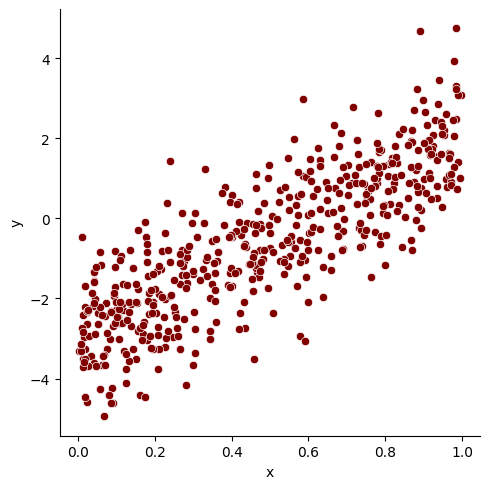

In [6]:
sns.relplot(
    data=df,
    x="x", y="y", color = 'maroon')

In [7]:
class FullyConnectedNetwork:
    __REGULARIZATION_GRAD = {None: lambda _w: 0, "l1": lambda _w: np.sign(_w), "l2": lambda _w: 2*_w}
    __REGULARIZATION_FUNC = {None: lambda _w: 0, "l1": lambda _w: np.abs(_w), "l2": lambda _w: _w ** 2}
    __LOSS = 0
    # создание нейронной сети: alpha — скорость обучения (шаг градиентного спуска), reg_type — тип регуляризации (если есть), lambda — параметр регуляризации; слои будут храниться в списке layers
    def __init__(self, alpha=0.01, reg_type=None, lambda_=0):
        self.__layers = list()
        self.__alpha = alpha
        self.__reg_type = reg_type
        self.__lambda = lambda_

    # метод, позволяющий добавить новый слой: указываем правильные размеры слоя, название функции активации, class_number — количество классов в случае использования Sotmax'а на последнем слое, параметр a — параметр LeakyReLU
    def add_layer(self, size: tuple, activation_func: str, class_number=0, a=0, loss=''):
        if not self.__layers or self.__layers[-1].size[1] == size[0]:
            self.__layers.append(FullyConnectedLayer(size, activation_func, class_number, a,loss))
        else:
            raise Exception("Wrong size of the layer!")

    def change_alpha(self, alpha):
        self.__alpha = alpha

    def get_loss(self):
        return FullyConnectedNetwork.__LOSS

    def mse_loss(self, predicted, target):
        return np.mean((predicted - target) ** 2)

    # метод, выдающий предсказания для заданного набора данных после обучения модели
    def predict(self, data):
        current_output = data
        for layer in self.__layers[:-1]:
            current_output, _ = layer.forward(current_output, None)
        # отдельно обрабатываем последний слой
        layer_weights, layer_biases = self.__layers[-1].get_weights()
        current_output = np.matmul(current_output, layer_weights) - layer_biases
        _exp_outputs = np.exp(current_output - np.amax(current_output))
        answ = np.transpose(np.transpose(_exp_outputs) / np.sum(_exp_outputs, axis=1))
        return np.array([np.argmax(_row) for _row in answ])

    def score(self, data, answers):
        return (self.predict(data) == answers).sum() / len(answers)

    def fit(self, data, answers):
        # выход входного слоя совпадает с фичами входных данных
        layer_outputs = [data]
        current_output = layer_outputs[0]
        grads = []
        # forward pass и вычисление градиентов функций активации
        for layer in self.__layers:
            current_output, gradient = layer.forward(current_output, answers)
            layer_outputs.append(current_output)
            grads.append(gradient)
        # для вычисления градиентов по правилу цепочки, удобно развернуть массив
        grads = grads[::-1]
        # для градиента параметров самого первого слоя, умножаем на «производную» независимой переменной
        grads.append(1)
        current_gradient = grads[0]
        FullyConnectedNetwork.__LOSS = layer_outputs[-1]
        for i, layer in enumerate(self.__layers[::-1]):
            layer_weights, layer_biases = layer.get_weights()
            FullyConnectedNetwork.__LOSS += self.__lambda * (np.sum(FullyConnectedNetwork.__REGULARIZATION_FUNC[self.__reg_type](layer_weights) + FullyConnectedNetwork.__REGULARIZATION_FUNC[self.__reg_type](layer_biases)))
            # вычисление градиента параметров W слоя layer
            d_weights = np.matmul(layer_outputs[-2 - i].T, current_gradient)
            # вычисление градиента параметров db слоя layer
            d_bias = -np.matmul(np.ones(layer_outputs[-2 - i].shape[0]), current_gradient) / layer_outputs[-2 - i].shape[0]
            # Вставьте здесь вычисление функции ошибки MSE или MAE
            loss = self.mse_loss(current_output, answers)  # или self.mae_loss(current_output, answers)
            # выполнение шага градиентного спуска
            layer.update_weights(self.__alpha * (d_weights + self.__lambda * FullyConnectedNetwork.__REGULARIZATION_GRAD[self.__reg_type](layer_weights)) , self.__alpha * (d_bias + self.__lambda * FullyConnectedNetwork.__REGULARIZATION_GRAD[self.__reg_type](layer_biases)))
            # правило цепочки
            current_gradient = np.matmul(current_gradient, layer_weights.T) * grads[i + 1]

    def predict_reg(self, data):
            current_output = data
            for layer in self.__layers[:-1]:
                current_output, _ = layer.forward(current_output, None)
            layer_weights, layer_biases = self.__layers[-1].get_weights()
            return np.matmul(current_output, layer_weights) - layer_biases

    # метод для отрисовки весов, первый параметр должен быть квадратом целого числа
    def print_weights(self, label="No label"):
        for layer in self.__layers:
            _pixel_weights, _bias = layer.get_weights()
            size = tuple([int(round((_pixel_weights.shape[0] - 1) ** 0.5)) for _ in range(2)])
            fig, axes = plt.subplots(ncols=5, nrows=2)
            fig.set_size_inches(20, 10)
            for j in range(10):
                axes[j // 5, j % 5].imshow((_pixel_weights[:, j]).reshape(size), cmap=plt.cm.gray, label=label)

    def mse_loss(self, predicted, target):
        return np.mean((predicted - target) ** 2)

    def mae_loss(self, predicted, target):
        return np.mean(np.abs(predicted - target))

# класс, отвечающий за слой в нейронной сети
class FullyConnectedLayer:
    # мы предполагаем, что реализованы следующие функции активации, на последнем слое возможно решение задачи классификации с Softmax
    __ACTIVATION_FUNCTIONS = {'ReLU': {'func': lambda a, x: np.maximum(x, 0), 'derivative': lambda a, x: np.where(x >= 0, 1, 0)},
                              'LReLU': {'func': lambda a, x: np.where(x >= 0, x, a*x), 'derivative': lambda a, x: np.where(x >= 0, 1, a)},
                              'None': {'func': lambda a, x: x, 'derivative': lambda a, x: 1},
                              'Sigmoid': {'func': lambda a, x: np.exp(x) / (1 + np.exp(x)), 'derivative': lambda a, x: np.exp(x) / (1 + np.exp(x)) ** 2},
                              'Softmax': {}}
    # создание нового слоя: задание размеров слоя, случайная (равномерная на [-1/2, 1/2]) инициализация весов, запоминание функции активации, фиксация количества классов в случае решения задачи классификации
    def __init__(self, size: tuple, activation_func: str, class_number=0, a=0, loss=''):
        self.size = size
        self.__weights = np.random.random((size[0], size[1])) - 0.5
        self.__bias = np.random.random((1, size[1])) - 0.5
        self.__a = a
        if activation_func in FullyConnectedLayer.__ACTIVATION_FUNCTIONS.keys():
            self.__activation_func = activation_func
        else:
            raise Exception("No such activation function!")
        if activation_func == 'Softmax':
            self.__class_number = class_number
        if activation_func == 'None':
            self.__loss = loss

    # метод, возвращающий значения весов: веса и смещения
    def get_weights(self):
        return self.__weights, self.__bias

    def get_activation_func(self):
        return self.__activation_func

    # метод, модифицирующий веса после градиентного шага
    def update_weights(self, d_weights, d_biases):
        self.__weights -= d_weights
        self.__bias -= d_biases

    # метод, возвращающий градиент
    def __get_grad(self, data, answers):
        if self.__activation_func == 'Softmax':
            return - (self.__one_hot(answers) - self.__get_probabilities(data)) / len(answers)
        else:
            return FullyConnectedLayer.__ACTIVATION_FUNCTIONS[self.__activation_func]['derivative'](self.__a, data)

    # one-hot encoding меток класса
    def __one_hot(self, answers):
        one_hot_answers = np.zeros((len(answers), self.__class_number))
        one_hot_answers[np.arange(len(answers)), answers] = 1
        return one_hot_answers

    # метод, возвращающий вероятности после Softmax'a
    def __get_probabilities(self, data):
        _outputs = np.matmul(data, self.__weights) - self.__bias
        _gamma = np.amax(_outputs)
        _exp_outputs = np.exp(_outputs - _gamma)
        return np.transpose(np.transpose(_exp_outputs) / np.sum(_exp_outputs, axis=1))

    def __mse_loss_grad(self, prediction, answers):
      activation =  np.mean((prediction - answers.reshape(-1,1)) ** 2)
      gradient = 2 * (prediction - answers.reshape(-1,1)) / len(answers)
      return activation, gradient

    def __mae_loss_grad(self, prediction, answers):
      activation =  np.mean(np.abs(prediction - answers.reshape(-1,1)))
      gradient = np.sign(prediction - answers.reshape(-1,1)) / len(answers)
      return activation, gradient

    # проход по слою с вычислением градиента функции активации на текущей итерации и текущем наборе данных, для последнего слоя нет нужды вычислять значение, если только не хочется узнать что-то про функцию потерь
    def forward(self, data, answers):
        if self.__activation_func == 'Softmax':
            matrix_pass = np.matmul(data, self.__weights) - self.__bias
            activation = - np.sum(matrix_pass * self.__one_hot(answers) - np.log(np.sum(np.exp(matrix_pass)))) / len(answers)
            gradient = self.__get_grad(data, answers)
        elif self.__activation_func =="None":
            matrix_pass = np.matmul(data, self.__weights) - self.__bias
            if self.__loss == 'MSE':
                activation, gradient = self.__mse_loss_grad(matrix_pass, answers)
            elif self.__loss == 'MAE':
                activation, gradient = self.__mae_loss_grad(matrix_pass, answers)
            else:
                raise Exception("No such loss function")
        else:
            matrix_pass = np.matmul(data, self.__weights) - self.__bias
            activation = FullyConnectedLayer.__ACTIVATION_FUNCTIONS[self.__activation_func]['func'](self.__a, matrix_pass)
            gradient = self.__get_grad(matrix_pass, answers)
        return activation, gradient

In [8]:
#loss = self.mse_loss(predicted, answers)  # вычисляем функцию ошибки MSE
#mnist_dataset = datasets.load_digits()

MSE

In [9]:
NN = FullyConnectedNetwork(alpha=0.1, reg_type='l2', lambda_=0.002)
loss = []
NN.add_layer((1, 48), activation_func='ReLU')
NN.add_layer((48, 1), activation_func='None', loss='MSE')
alpha = 0.1
for ep in range(1000):
    NN.fit(x1, y1)
    loss.append((ep, NN.get_loss()))
    if (ep + 1) % 100 == 0:
        alpha = alpha / 10
        NN.change_alpha(alpha)
        print('R2:',  r2_score(y1, NN.predict_reg(x1)), 'MSE:',  mean_squared_error(y1, NN.predict_reg(x1)))

R2: 0.6857635986257791 MSE: 1.0377930815132967
R2: 0.6858325993265394 MSE: 1.0375652006899567
R2: 0.6858388698301155 MSE: 1.0375444918058159
R2: 0.6858395043518559 MSE: 1.0375423962425092
R2: 0.6858395677860971 MSE: 1.0375421867454038
R2: 0.6858395741293419 MSE: 1.037542165796285
R2: 0.6858395747636646 MSE: 1.0375421637013793
R2: 0.6858395748270968 MSE: 1.0375421634918889
R2: 0.68583957483344 MSE: 1.0375421634709399
R2: 0.6858395748340744 MSE: 1.0375421634688449


In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x1, y1)
print('R2: ', model.score(x1, y1))

R2:  0.687344428647928


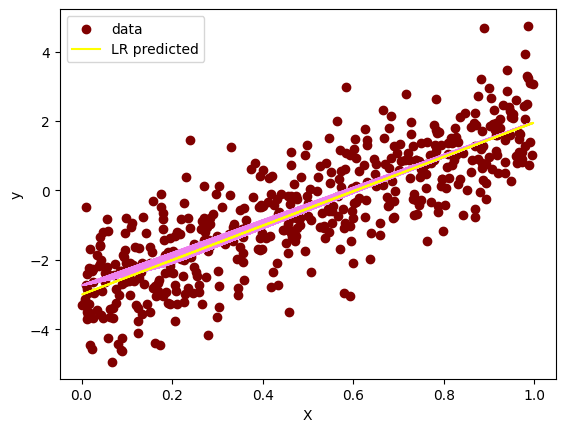

In [26]:
plt.scatter(x1, y1, label='data', color = 'maroon')
plt.plot(x1, NN.predict_reg(x1), color = 'violet')
plt.plot(x1, model.predict(x1), color='yellow', label='LR predicted')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()